## Estimation of subjective income risk profile using SCE data


- This notebook does the estimation of the Markov switching model for income risk perceptions using data from SCE 
- parameters to estimate:
   - $\tilde \Gamma_l$ and $\tilde \Gamma_h$ 
   - transition matrix $\Omega$ with $p$ and $q$ as the staying probability in low and high risk states, respectively.
  - where $\tilde \Gamma_l = \{\tilde \sigma^l_\psi,\tilde \sigma^l_\theta, \tilde{\mho^l}, \tilde{E^l}\}$ and $\tilde \Gamma_h = \{\tilde \sigma^h_\psi,\tilde \sigma^h_\theta, \tilde{\mho^h}, \tilde{E^h}\}$ where we impose the restriction that $\tilde \sigma^h_\psi > \tilde \sigma^l_\psi$ and $\tilde \sigma^h_\theta > \tilde \sigma^l_\theta$, $\tilde{\mho^h}>\tilde{\mho^l}$, and $\tilde{E^h}<\tilde{E^l}$.
 
  
Possible extensions (not implemented yet)
- Specific to group, such as to age and education. 
- Conditional on macroeconomic cycles or labor market tightness

In [4]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

from Utility import mkv2_M2Q, mkv2_Y2Q

In [5]:
from MarkovSwitchingEst import Markov2Switching
from MarkovSwitchingEst import steady_state,prob_func,prob_func_inv,exp_func,exp_func_inv

### Estimation of SCE data

In [6]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

## precision of showing float  
pd.options.display.float_format = '{:,.3f}'.format

In [7]:
## import data 
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

## variables 
vars_id = ['userid','date']
moms_nom = ['Q24_mean','Q24_iqr','Q24_var']
moms_real = ['Q24_rmean','Q24_rvar']
ue_risks = ['Q13new','Q22new']
vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36',  ## education (1-8 low to high, 9 other)
                  'educ_gr',##education group (1-3)
                  'byear', ## year of birth
                  'tenure', ## nb of months staying in the survey 
                   'nlit'] 

vars_all_reg_long = (vars_id+moms_nom + moms_real+ue_risks+vars_demog+vars_demog_sub+vars_job)

## select dataset 
SCEM = dataset[vars_all_reg_long]


SCEM = SCEM.rename(columns={'Q24_mean': 'incexp',
                           'Q24_var': 'incvar',
                           'Q24_iqr': 'inciqr',
                           'Q24_rmean':'rincexp',
                           'Q24_rvar': 'rincvar',
                           'Q13new':'UE_s',
                           'Q22new':'UE_f'
                           })


SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ'})

SCEM = SCEM.dropna(subset=['date'])

## add year and month variable 
SCEM['year'] = SCEM.date.dt.year
SCEM['month'] = SCEM.date.dt.month 


## new variables 
SCEM['age2']=SCEM['age']**2
SCEM['age3']=SCEM['age']**3
SCEM['age4']=SCEM['age']**4

## take the log 
SCEM['erincexp'] = np.exp(1+SCEM['rincexp'])
SCEM['lrincvar'] = np.log(SCEM['rincvar'])

### some data transformation 

SCEM['UE_s'] = SCEM['UE_s']/100
SCEM['UE_f'] = SCEM['UE_f']/100

SCEM['U2U_prob'] = 1-SCEM['UE_f']   #. 1- prob of find a job
SCEM['E2E_prob'] = 1- SCEM['UE_s']*(1-SCEM['UE_f'])   ## 1- prob(loses the job and not finding one)


## trucate 0 and 1s for probs 
SCEM['U2U_prob_truc'] = SCEM['U2U_prob']
SCEM['U2U_prob_truc'] = SCEM['U2U_prob_truc'].mask(SCEM['U2U_prob_truc']>=1.0,0.99)
SCEM['U2U_prob_truc'] = SCEM['U2U_prob_truc'].mask(SCEM['U2U_prob_truc']<=0.0,0.01)


SCEM['E2E_prob_truc'] = SCEM['E2E_prob']
SCEM['E2E_prob_truc'] = SCEM['E2E_prob_truc'].mask(SCEM['E2E_prob_truc']>=1.0,0.99)
SCEM['E2E_prob_truc'] = SCEM['E2E_prob_truc'].mask(SCEM['E2E_prob_truc']<=0.0,0.01)


### transform 0-1 prob to a R 

prob_inv_func = lambda x: np.log(x)-np.log(1-x)
SCEM['U2U_prob_e'] = SCEM['U2U_prob_truc'].apply(prob_inv_func)
SCEM['E2E_prob_e'] =  SCEM['E2E_prob_truc'].apply(prob_inv_func)

In [8]:
## filter by basic/necessary criteria  
print('nb of observations before:',str(len(SCEM)))
SCEM = SCEM[SCEM['tenure']>=6]
SCEM = SCEM[SCEM['fulltime']==1]
SCEM = SCEM[SCEM['selfemp']==1]  ## working for someone 
SCEM =SCEM[(SCEM['age']<=65) & (SCEM['age']>=25) ]
SCEM =SCEM[SCEM['nlit']>=3.0]
SCEM =SCEM[SCEM['educ']>=2]
print('nb of observations after dropping low numeracy/low education sample:',str(len(SCEM)))

nb of observations before: 115083
nb of observations after dropping low numeracy/low education sample: 19731


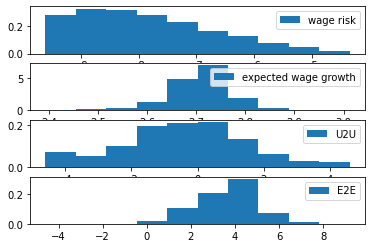

In [9]:
## first step regression

vars_list = ['lrincvar',
             'erincexp',
            'U2U_prob_e',
            'E2E_prob_e']  
var_name = ['wage risk',
            'expected wage growth',
            'U2U',
            'E2E']

sd_fe_list = []

fig,axes = plt.subplots(len(vars_list),1)


for i,var in enumerate(vars_list):
    ## demeaned 
    SCEM[var+'_dm'] = SCEM[var]-SCEM.groupby('userid')[var].transform('mean')
    sd_fe_list.append(SCEM.groupby('userid')[var].transform('mean').std())

    ## plot initial fixed effects
    axes[i].hist(SCEM.groupby('userid')[var].transform('mean'),
                 label=var_name[i],
                 density=True)
    axes[i].legend()
    ## run a panel regression to get the residuls 
    #model = smf.ols(formula = var+'~ C(date)+C(HHinc)+C(gender)+age2+age3+age4+C(educ_gr)',
    #            data = SCEM)
    model = smf.ols(formula = var+'_dm~ C(date)',
                data = SCEM)
    result = model.fit()
    residuls = result.resid
    SCEM[var+'_rd'] = residuls

In [10]:
## correlation 
print('unconditional correlation')
SCEM[vars_list].corr()

unconditional correlation


,lrincvar,erincexp,U2U_prob_e,E2E_prob_e
lrincvar,1.000,0.059,0.040,-0.097
erincexp,0.059,1.000,-0.082,0.093
U2U_prob_e,0.040,-0.082,1.000,-0.492
E2E_prob_e,-0.097,0.093,-0.492,1.000


In [3]:
## individual fixed effects

print('std of ex-ante wage risks',sd_fe_list[0])
print('std of ex-ante wage growth exp',sd_fe_list[1])
print('std of ex-ante U2E',sd_fe_list[2])
print('std of ex-ante E2E',sd_fe_list[3])

NameError: name 'sd_fe_list' is not defined

In [14]:
## convert the panel data of rincvar into a list of time series sequence
vars_rd_list = ['lrincvar',
                'erincexp',
                'U2U_prob_e',
                'E2E_prob_e'
                ]

In [15]:
## correlation 
print('residual correlation')
SCEM[vars_rd_list].corr()

residual correlation


,lrincvar,erincexp,U2U_prob_e,E2E_prob_e
lrincvar,1.000,0.059,0.040,-0.097
erincexp,0.059,1.000,-0.082,0.093
U2U_prob_e,0.040,-0.082,1.000,-0.492
E2E_prob_e,-0.097,0.093,-0.492,1.000


In [16]:
## convert it to a list of arrays storing all time series data for each individual

SCEM_sub = SCEM[['userid']+vars_rd_list].dropna(how='any')

unique_ids = list(SCEM_sub['userid'].unique())

SCE_list = [SCEM_sub[SCEM_sub['userid']==ID][vars_rd_list].T.to_numpy() for ID in unique_ids]

SCE_list = [x for x in SCE_list if ~np.isnan(np.array(x)).any() and x.shape[1]>=3]

print('how many invidividuals have answers in successive months?',len(SCE_list))

how many invidividuals have answers in successive months? 2704


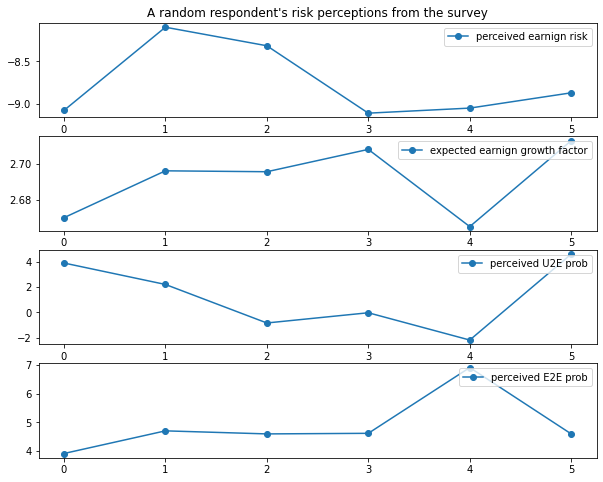

In [19]:
## plot the simulated data 
random_id = np.random.randint(0,len(SCE_list)-1)

fig, axes = plt.subplots(len(vars_rd_list),
                         1,
                         figsize=(10,8))
axes[0].set_title("A random respondent's risk perceptions from the survey")
axes[0].plot(SCE_list[random_id][0,:],
         'o-',
         label='perceived earning risk')
axes[0].legend(loc=1)

axes[1].plot(SCE_list[random_id][1,:],
         'o-',
         label='expected earning growth factor')
axes[1].legend(loc=1)

axes[2].plot(SCE_list[random_id][2,:],
         'o-',
         label='perceived U2E prob')
axes[2].legend(loc=1)

axes[3].plot(SCE_list[random_id][3,:],
         'o-',
         label='perceived E2E prob')
axes[3].legend(loc=1)
fig.savefig('../Graphs/sce/markov_example.png')

In [20]:
## initialize the model based on the SCE  

AR = 1
nb_var = 4

## impose bounds on some parameters with sensible priors

## the size of the shock cannot exceed the sample variation
sigma_ub0 = np.mean([np.std(np.array(x[0,:])) for x in SCE_list])
sigma_inv_ub0 = exp_func_inv(sigma_ub0)

sigma_ub1 = np.mean([np.std(np.array(x[1,:])) for x in SCE_list])
sigma_inv_ub1 = exp_func_inv(sigma_ub1)

sigma_ub2 = np.mean([np.std(np.array(x[2,:])) for x in SCE_list])
sigma_inv_ub2 = exp_func_inv(sigma_ub1)

## staying probabilities of both 2 states are above half 
q_lb = 0.5  ## persistent 
q_inv_lb = prob_func_inv(q_lb)
p_lb = 0.5 ## persistent 
p_inv_lb = prob_func_inv(p_lb)


if AR ==0:
    if nb_var==3:
        paras_init = np.array([0.1,0.1,0.1,0.7,0.7,
                               0.1,0.1,0.1,0.7,0.7,
                               0.1,-0.1,0.1,0.7,0.7])
        guess = np.array([0.2,0.4,-0.5,0.1,0.4,
                0.2,0.4,-2,0.1,0.4,
                0.2,-0.1,-2,0.1,0.4])


        bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub0),(q_lb,None),(p_inv_lb,None),
                 (None,None),(0.0,None),(-3,sigma_inv_ub1),(None,None),(None,None),
                 (None,None),(None,0.0),(-3,sigma_inv_ub2),(None,None),(None,None),)
    elif nb_var ==4:
        paras_init = np.array([0.1,0.1,0.1,0.7,0.7,
                               0.1,0.1,0.1,0.7,0.7,
                               0.1,0.1,0.1,0.7,0.7,
                               0.1,-0.1,0.1,0.7,0.7])
        guess = np.array([0.2,0.4,-0.5,0.1,0.4,
                          0.2,0.4,-0.5,0.1,0.4,
                        0.2,0.4,-2,0.1,0.4,
                        0.2,-0.1,-2,0.1,0.4])


        bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub0),(q_lb,None),(p_inv_lb,None),
                  (None,None),(None,None),(-1,sigma_inv_ub0),(q_lb,None),(p_inv_lb,None),
                 (None,None),(0.0,None),(-3,sigma_inv_ub1),(None,None),(None,None),
                 (None,None),(None,0.0),(-3,sigma_inv_ub2),(None,None),(None,None),)
        
    elif nb_var ==1:
        paras_init = np.array([0.1,0.1,0.1,0.7,0.7])
        guess = np.array([0.2,0.4,-0.5,0.4,0.8])
        bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub0),(q_lb,None),(p_inv_lb,None),)

elif AR==1:
    if nb_var==3:
        paras_init= np.array([0.1,0.1,0.1,0.7,0.7,0.8,
                              0.1,0.1,0.1,0.7,0.7,0.8,
                              0.1,-0.1,0.1,0.7,0.7,0.9])
        guess = np.array([0.2,0.4,-0.5,0.1,0.4,0.8,
                        0.2,0.4,-2,0.1,0.4,0.8,
                        0.2,-0.1,-2,0.1,0.4,0.8])
        
        bounds = ((None,None),(0.0,None),(-1,None),(q_lb,None),(None,None),(None,None),
                 (None,None),(0.0,None),(-3,None),(None,None),(None,None),(None,None),
                 (None,None),(None,0.0),(-3,None),(None,None),(None,None),(None,None),)
    elif nb_var==4:
        paras_init= np.array([0.1,0.1,0.1,0.7,0.7,0.8,
                              0.1,0.1,0.1,0.7,0.7,0.8,
                              0.1,0.1,0.1,0.7,0.7,0.8,
                              0.1,-0.1,0.1,0.7,0.7,0.9])
        guess = np.array([0.2,0.4,-0.5,0.1,0.4,0.8,
                          0.2,0.4,-0.5,0.1,0.4,0.8,
                        0.2,0.4,-2,0.1,0.4,0.8,
                        0.2,-0.1,-2,0.1,0.4,0.8])
        
        bounds = ((None,None),(0.0,None),(-1,None),(q_lb,None),(None,None),(None,None),
                  (None,None),(0.0,None),(-1,None),(q_lb,None),(None,None),(None,None),
                 (None,None),(0.0,None),(-3,None),(None,None),(None,None),(None,None),
                 (None,None),(None,0.0),(-3,None),(None,None),(None,None),(None,None),)
    elif nb_var==1:
        paras_init= np.array([0.1,0.1,0.1,0.7,0.7,0.8])
        
        guess = np.array([0.2,0.4,-0.5,0.1,0.4,0.8])
        
        bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub0),(q_lb,None),(p_inv_lb,None),(None,None),)



## model instance
SCE_mkv2 = Markov2Switching(AR=AR,
                            paras=paras_init,
                            nb_var=nb_var)


## objective func
SCE_obj = lambda para: -SCE_mkv2.log_likelihood(SCE_list,
                                                para)[0]   ## only the first output

In [24]:
result = minimize(SCE_obj,
                  x0 = guess,
                  method='Nelder-Mead',   #SLSQP trust-constr
                  #bounds = bounds,
                  options={'disp': True,
                            'maxiter':20000}
                   )
print('success? ',result['success'])
SCE_para_est = result['x']
## get alpha, beta, sigma, q, p 

## get model parameters 
guess_para_model = SCE_mkv2.make_para_dict(guess)
SCE_para_model_est = SCE_mkv2.make_para_dict(SCE_para_est)

#results
print("initial guess of the parameters\n",guess_para_model)
print("estimated parameters\n",SCE_para_model_est)

KeyboardInterrupt: 

In [62]:
## get the kappa 

risks_est = pd.read_stata('../OtherData/sipp/sipp_history_vol_decomposed.dta')
## risks of permanent and transitory component 

## p/t ratio 
kappas_sipp  = risks_est['permanent']/risks_est['transitory']
kappa_sipp = np.median(kappas_sipp.dropna())
kappa = kappa_sipp ## ratio of permanent and transitory risks

print(kappa)

1.7621756968902875


In [39]:
## create a dictionary for storing QUARTERLY parameters 

model_para_q_est = {}

############################################
## from yearly to monthly risk then to quarterly
############################################

## ex-ante heterogeneity
model_para_q_est['\tilde\sigma_std'] = sd_fe_list[0]

if nb_var==3:
    model_para_q_est['\tilde \mho^l_std'] = sd_fe_list[1]
    model_para_q_est['\tilde E^l_std'] = sd_fe_list[2]
elif nb_var==4:
    model_para_q_est['\tilde G_std'] = sd_fe_list[1]
    model_para_q_est['\tilde \mho^l_std'] = sd_fe_list[2]
    model_para_q_est['\tilde E^l_std'] = sd_fe_list[3]
else:
    pass

## stochastic heterogeneity
model_para_q_est['q'],model_para_q_est['p'] = mkv2_M2Q(SCE_para_model_est['q'],
                                                   SCE_para_model_est['p'])

alpha = SCE_para_model_est['α'][0]
beta = SCE_para_model_est['β'][0]


model_para_q_est['\tilde\sigma_\psi^l'] = np.sqrt(3*np.exp(alpha)/(12+1/(12*kappa**2)))
model_para_q_est['\tilde\sigma_\theta^l'] =  1/3*model_para_q_est['\tilde\sigma_\psi^l']/kappa
model_para_q_est['\tilde\sigma_\psi^h'] =  np.sqrt(3*np.exp(alpha+beta)/(12+1/(12*kappa**2)))
model_para_q_est['\tilde\sigma_\theta^h'] =  1/3*model_para_q_est['\tilde\sigma_\psi^h']/kappa

if nb_var==3:
    alpha_q = SCE_para_model_est['α'][1]
    beta_q = SCE_para_model_est['α'][1]+SCE_para_model_est['β'][1]

    alpha_p = SCE_para_model_est['α'][2]
    beta_p = SCE_para_model_est['α'][2]+SCE_para_model_est['β'][2]

    model_para_q_est['\tilde \mho^l'],model_para_q_est['\tilde E^l'] = mkv2_Y2Q(SCE_mkv2.prob_func(alpha_q),
                                                                            SCE_mkv2.prob_func(alpha_p))

    model_para_q_est['\tilde \mho^h'], model_para_q_est['\tilde E^h']=  mkv2_Y2Q(SCE_mkv2.prob_func(alpha_q+beta_q),
                                                                             SCE_mkv2.prob_func(alpha_p+beta_p))
    
elif nb_vars ==4:
    alpha_rexp = SCE_para_model_est['α'][1]
    beta_rexp = SCE_para_model_est['α'][1]+SCE_para_model_est['β'][1]
    
    alpha_q = SCE_para_model_est['α'][2]
    beta_q = SCE_para_model_est['α'][2]+SCE_para_model_est['β'][2]

    alpha_p = SCE_para_model_est['α'][3]
    beta_p = SCE_para_model_est['α'][3]+SCE_para_model_est['β'][3]

    
    model_para_q_est['\tilde \mho^l'],model_para_q_est['\tilde E^l'] = mkv2_Y2Q(SCE_mkv2.prob_func(alpha_q),
                                                                            SCE_mkv2.prob_func(alpha_p))

    model_para_q_est['\tilde \mho^h'], model_para_q_est['\tilde E^h']=  mkv2_Y2Q(SCE_mkv2.prob_func(alpha_q+beta_q),
                                                                             SCE_mkv2.prob_func(alpha_p+beta_p))
else:
    pass
print('quarterly SCE parameters\n',model_para_q_est)


## convert to a dataframe 

SCE_para_est_q_df = pd.DataFrame.from_dict(model_para_q_est,
                                         orient='index',
                                         dtype=None, 
                                         columns=['baseline']
                                        )

## output tables 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width=0.3\\textwidth}
\\begin{threeparttable}
\\caption{Estimated subjective risk perceptions}
\\label{tab:PRMarkovEst}"""

endtex = """\\begin{tablenotes}\item This table reports estimates of the parameters 
for the 2-state Markov switching model of subjective risk perceptions. Risks are at the monthly frequency. 
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""


## write to latex 
f = open('../Tables/latex/PRMarkovEst.tex', 'w')
f.write(beginningtex)
tb_ltx = SCE_para_est_q_df.to_latex()
f.write(tb_ltx)
f.write(endtex)
f.close()



## presentable tables 

if nb_var>1:
    index_names = ['$std(\tilde\sigma)$',
                   '$std(\tilde\mho)$',
                   '$std(\tilde E)$',
                   '$q$',
                  '$p$',
                  '$\tilde\sigma^l_\psi$',
                  '$\tilde\sigma^l_\theta$',
                  '$\tilde\sigma^h_\psi$',
                  '$\tilde\sigma^h_\theta$',
                  '$\tilde \mho^l$',
                  '$\tilde \mho^h$',
                  '$\tilde E^l$',
                  '$\tilde E^h$']
else:
    index_names = ['$std(\tilde\sigma)$',
                   '$q$',
                  '$p$',
                  '$\tilde\sigma^l_\psi$',
                  '$\tilde\sigma^l_\theta$',
                  '$\tilde\sigma^h_\psi$',
                  '$\tilde\sigma^h_\theta$',
                  #'$\tilde \mho^l$',
                  #'$\tilde \mho^h$',
                  #'$\tilde E^l$',
                  #'$\tilde E^h$'
                   ]


SCE_para_est_q_df.index = index_names


## save it to a pickle file 
SCE_para_est_q_df.to_pickle('data/subjective_profile_est_q.pkl')

SCE_para_est_q_df


quarterly SCE parameters
 {'\tilde\\sigma_std': 1.1896588802337646, 'q': 0.9756941348780334, 'p': 0.9756941348780334, '\tilde\\sigma_\\psi^l': 0.48753147082825726, '\tilde\\sigma_\theta^l': 0.0922215024091344, '\tilde\\sigma_\\psi^h': 1.3913052720696557, '\tilde\\sigma_\theta^h': 0.2631794462048427}


,baseline
$std(\tilde\sigma)$,1.190
$q$,0.976
$p$,0.976
$\tilde\sigma^l_\psi$,0.488
$\tilde\sigma^l_\theta$,0.092
$\tilde\sigma^h_\psi$,1.391
$\tilde\sigma^h_\theta$,0.263


In [36]:
## create a dictionary for storing YEARLY parameters 

model_para_y_est = {}

############################################
## from yeraly to monthly risk
############################################

###!!!! Here you need to transform montly mkv to 1 year

## ex-ante heterogeneity
model_para_y_est['\tilde\sigma_std'] = sd_fe_list[0]

if nb_var>1:
    model_para_y_est['\tilde \mho^l_std'] = sd_fe_list[1]
    model_para_y_est['\tilde E^l_std'] = sd_fe_list[2]
else:
    pass

model_para_y_est['q'],model_para_y_est['p'] = mkv2_M2Q(SCE_para_model_est['q'],
                                                   SCE_para_model_est['p'])

alpha = SCE_para_model_est['α'][0]
beta = SCE_para_model_est['β'][0]

model_para_y_est['\tilde\sigma_\psi^l'] = np.sqrt(12*np.exp(alpha)/(12+1/(12*kappa**2)))
model_para_y_est['\tilde\sigma_\theta^l'] =  1/12*model_para_q_est['\tilde\sigma_\psi^l']/kappa
model_para_y_est['\tilde\sigma_\psi^h'] =  np.sqrt(12*np.exp(alpha+beta)/(12+1/(12*kappa**2)))
model_para_y_est['\tilde\sigma_\theta^h'] =  1/12*model_para_q_est['\tilde\sigma_\psi^h']/kappa

if nb_var>1:
    alpha_q = SCE_para_model_est['α'][1]
    beta_q = SCE_para_model_est['α'][1]+SCE_para_model_est['β'][1]

    alpha_p = SCE_para_model_est['α'][2]
    beta_p = SCE_para_model_est['α'][2]+SCE_para_model_est['β'][2]


    model_para_y_est['\tilde \mho^l'],model_para_y_est['\tilde E^l'] = SCE_mkv2.prob_func(alpha_q),SCE_mkv2.prob_func(alpha_p)

    model_para_y_est['\tilde \mho^h'], model_para_y_est['\tilde E^h']=  SCE_mkv2.prob_func(alpha_q+beta_q),SCE_mkv2.prob_func(alpha_p+beta_p)

else:
    pass

print('yearly SCE parameters\n',model_para_y_est)


## convert to a dataframe 


SCE_para_est_y_df = pd.DataFrame.from_dict(model_para_y_est,
                                         orient='index',
                                         dtype=None, 
                                         columns=['baseline']
                                        )

## output tables 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width=0.3\\textwidth}
\\begin{threeparttable}
\\caption{Estimated subjective risk perceptions (yearly)}
\\label{tab:PRMarkovEst}"""

endtex = """\\begin{tablenotes}\item This table reports estimates of the parameters 
for the 2-state Markov switching model of subjective risk perceptions. Risks are at the monthly frequency. 
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""


## write to latex 
f = open('../Tables/latex/PRMarkovEst_y.tex', 'w')
f.write(beginningtex)
tb_ltx = SCE_para_est_y_df.to_latex()
f.write(tb_ltx)
f.write(endtex)
f.close()


## presentable tables

SCE_para_est_y_df.index = index_names


## save it to a pickle file 
SCE_para_est_y_df.to_pickle('data/subjective_profile_est_y.pkl')

SCE_para_est_y_df



yearly SCE parameters
 {'\tilde\\sigma_std': 1.2030704021453857, 'q': 0.9737703075687916, 'p': 0.9737703075687916, '\tilde\\sigma_\\psi^l': 0.9744824195987942, '\tilde\\sigma_\theta^l': 0.023041649150877894, '\tilde\\sigma_\\psi^h': 2.6618301931632913, '\tilde\\sigma_\theta^h': 0.06293900862299147}


,baseline
$std(\tilde\sigma)$,1.203
$q$,0.974
$p$,0.974
$\tilde\sigma^l_\psi$,0.974
$\tilde\sigma^l_\theta$,0.023
$\tilde\sigma^h_\psi$,2.662
$\tilde\sigma^h_\theta$,0.063
